# Price prediction of USD EUR pair

As raw data we have daylie currency prices of the last ~20 years in an xml file.

First lets convert the values of the file to a Dataframe.

In [1]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [2]:
from bs4 import BeautifulSoup
import pandas as pd


# Reading the data inside the xml
# file to a variable under the name 
# data
with open('data/usd.xml', 'r') as f:
    data = f.read()

# Passing the stored data inside
# the beautifulsoup parser, storing
# the returned object 
soup = BeautifulSoup(data, "xml")

time_periods = [obs['TIME_PERIOD'] for obs in soup.find_all('Obs')]
values = [obs['OBS_VALUE'] for obs in soup.find_all('Obs')]

data = pd.DataFrame({'Timestamp': time_periods, 'Price': values})

data.head


<bound method NDFrame.head of        Timestamp   Price
0     1999-01-04  1.1789
1     1999-01-05  1.1790
2     1999-01-06  1.1743
3     1999-01-07  1.1632
4     1999-01-08  1.1659
...          ...     ...
6603  2024-10-14  1.0915
6604  2024-10-15  1.0903
6605  2024-10-16  1.0897
6606  2024-10-17  1.0866
6607  2024-10-18  1.0847

[6608 rows x 2 columns]>

Check if the data is already clean

In [14]:
# Convert OBS_VALUE to numeric
data['Price'] = pd.to_numeric(data['Price'])

# Get all statistical info
stats = data['Price'].describe()

print(stats)

count    6608.000000
mean        1.185255
std         0.155542
min         0.825200
25%         1.085600
50%         1.176050
75%         1.303225
max         1.599000
Name: Price, dtype: float64


# Prepare data for the model
To do this we will create lagged features and split the data into training and testset.
But first we will fill out the weekend gaps.

In [15]:
# Convert TIME_PERIOD to datetime and OBS_VALUE to numeric
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Price'] = pd.to_numeric(data['Price'])

# Set TIME_PERIOD as index
data.set_index('Timestamp', inplace=True)

# Resample to include all days and fill gaps (e.g., using forward-fill)
df_resampled = data.resample('D').ffill()  # Use 'D' for daily frequency

data.tail(10)
data.info()

KeyError: 'Timestamp'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


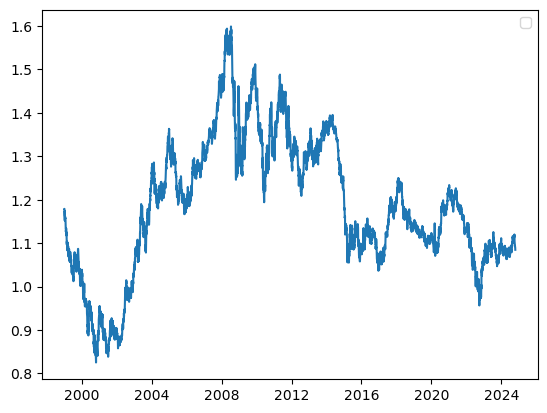

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6608 entries, 1999-01-04 to 2024-10-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   6608 non-null   float64
dtypes: float64(1)
memory usage: 103.2 KB


In [21]:
# Plot the data
from matplotlib import pyplot as plt

plt.plot(data.index, data['Price'])
plt.legend()
plt.show()

data.info()


In [33]:
# create lagged features

import numpy as np

def create_sequences(data, n_timesteps):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        # Input sequence (last n_timesteps of humidity, light, temperature)
        X.append(data[i:i + n_timesteps])
        # Target (humidity and temperature for the next timestep)
        y.append(data.iloc[i+n_timesteps]['Price'])  # 0 for humidity, 2 for temperature
    return np.array(X), np.array(y)

n_timesteps = 5  # Use past 12 time steps (1 Hour) to predict the next step
X, y = create_sequences(data, n_timesteps)
dates = data.index.to_numpy()
print(dates[0:5])

print(X.shape)
print(X[0])
print(y.shape)
print(y[0])

['1999-01-04T00:00:00.000000000' '1999-01-05T00:00:00.000000000'
 '1999-01-06T00:00:00.000000000' '1999-01-07T00:00:00.000000000'
 '1999-01-08T00:00:00.000000000']
(6603, 5, 1)
[[1.1789]
 [1.179 ]
 [1.1743]
 [1.1632]
 [1.1659]]
(6603,)
1.1569


In [37]:
# create the test and train set
TEST_SPLIT = 0.01

#data = data.drop(columns = ['Wind', 'Solar'])
train_size = int(len(X) * (1-TEST_SPLIT))
test_size = len(X) - train_size

dates_train = dates[0:train_size]
dates_test = dates[train_size:len(y)]
X_train = X[0:train_size]
X_test = X[train_size:len(y)]
y_train = y[0:train_size]
y_test = y[train_size:len(y)]

# Modelling

In [7]:
# create the model

import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((n_timesteps, 1))) # 1 features
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear')) # 1 Outputwert

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [8]:
cp = ModelCheckpoint('models/model.h5', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [9]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[cp])

Epoch 1/50
184/184 [==============================] - 5s 10ms/step - loss: 0.0692 - root_mean_squared_error: 0.2631 - val_loss: 6.6184e-04 - val_root_mean_squared_error: 0.0257
Epoch 2/50
184/184 [==============================] - 1s 5ms/step - loss: 5.5733e-04 - root_mean_squared_error: 0.0236 - val_loss: 2.6892e-04 - val_root_mean_squared_error: 0.0164
Epoch 3/50
184/184 [==============================] - 1s 5ms/step - loss: 2.0830e-04 - root_mean_squared_error: 0.0144 - val_loss: 7.7770e-05 - val_root_mean_squared_error: 0.0088
Epoch 4/50
184/184 [==============================] - 1s 5ms/step - loss: 1.4044e-04 - root_mean_squared_error: 0.0119 - val_loss: 8.3039e-05 - val_root_mean_squared_error: 0.0091
Epoch 5/50
184/184 [==============================] - 1s 5ms/step - loss: 1.3467e-04 - root_mean_squared_error: 0.0116 - val_loss: 7.5715e-05 - val_root_mean_squared_error: 0.0087
Epoch 6/50
184/184 [==============================] - 1s 5ms/step - loss: 1.3612e-04 - root_mean_square

# Testing

In [10]:
from keras.models import load_model
model = load_model('models/model.h5')

3/3 [==============================] - 0s 2ms/step


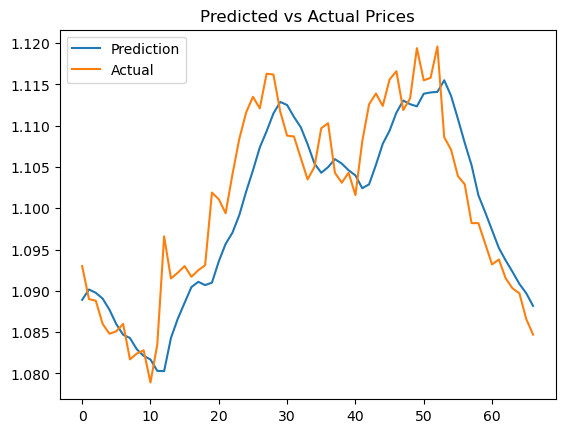

In [43]:
from matplotlib import pyplot as plt


# plot the test data
def plot_predictions(model, X, y, start=0, end=100):
    y_predictions = model.predict(X)
    # convert to df
    df_y_predictions = pd.DataFrame(y_predictions.flatten(), columns=['Predictions Price'])
    df_y_actuals = pd.DataFrame(y.flatten(), columns=['Actuals Price'])
    df_dates = pd.DataFrame(dates_test, columns=['Timestamp'])
    # Combine actual and predicted prices into a single DataFrame
    df = pd.DataFrame({'Timestamp': df_dates['Timestamp'],
                       'Predictions Price': df_y_predictions['Predictions Price'],
                       'Actuals Price': df_y_actuals['Actuals Price']})
    # Set TIME_PERIOD as index
    # df.set_index('Timestamp', inplace=True)
    
    # # Plot the data
    # plt.figure(figsize=(10,6))
    plt.plot(df['Predictions Price'])
    plt.plot(df['Actuals Price'])
    plt.legend(['Prediction', 'Actual'])
    plt.title('Predicted vs Actual Prices')
    plt.show()
    
    # Return the DataFrame for further inspection
    return df

df = plot_predictions(model, X_test, y_test)

In [49]:
# Find entry and exit points
# We only trade the global min and max of the forecast
min_global = df['Predictions Price'].min()
max_global = df['Predictions Price'].max()

# Finding the corresponding timestamps
min_time = df.loc[df['Predictions Price'] == min_global, 'Timestamp'].values[0]
max_time = df.loc[df['Predictions Price'] == max_global, 'Timestamp'].values[0]

print(f"Global Minimum: {min_global} at {min_time}")
print(f"Global Maximum: {max_global} at {max_time}")

Global Minimum: 1.0802773237228394 at 2024-07-29T00:00:00.000000000
Global Maximum: 1.1155058145523071 at 2024-09-24T00:00:00.000000000
